## Import Libraries

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from pylab import rcParams
import pywt
from skimage import exposure
from skimage.metrics import structural_similarity as ssim
import torch
import torch.nn.functional as F
import scipy
from matplotlib.gridspec import GridSpec
import string
import matplotlib.ticker as ticker

## Model dimensions

In [2]:
DH = 10.
NX = 600
NY = 350

## Used functions

In [3]:
def read_model(file_path, NX, NY):
    with open(file_path, "rb") as f:
        data_type = np.dtype("<f4")
        data = np.fromfile(f, dtype=data_type).reshape(NX, NY).T[::-1] #.T[::-1] is to transpose and flip the array
    return data

def calculate_metrics(image_gt, image_prd):
    metrics = {}

    # Structural Similarity Index (SSIM)
    metrics['ssim_index'] = ssim(image_gt, image_prd)

    # Frobenius norm
    metrics['frobenius_norm'] = np.linalg.norm(image_gt - image_prd, 'fro')
    # L1 norm
    metrics['l1_norm_value'] = np.sum(np.abs(image_gt - image_prd))
    # L2 norm
    metrics['l2_norm_value'] = np.sqrt(np.sum((image_gt - image_prd) ** 2))
    # MSE
    metrics['mse'] = np.mean((image_gt - image_prd) ** 2)
    # RMSE
    metrics['rmse'] = np.sqrt(metrics['mse'])

    return metrics

def scale_data(data):
    min_val, max_val = data.min(), data.max()
    scaled = (data - min_val) / (max_val - min_val)
    return scaled, min_val, max_val

def rescale_data(data, min_val, max_val):
    return data * (max_val - min_val) + min_val

def normalize_to_unit_range(data):
    if data.min() == data.max():
        return np.zeros_like(data)  
    return (data - data.min()) / (data.max() - data.min())

## Read data

In [4]:
basename = "/wt_test/Kimberlina/model.vp"
name_vp = basename    # Baseline model (smoothed)
vp = read_model(name_vp, NX, NY)
vp = np.flipud(vp)

print("vp min:", vp.min(), "vp max:", vp.max())
print("vp shape:", vp.shape)

vp min: 1975.2448 vp max: 3895.6353
vp shape: (350, 600)


In [5]:
vp_upsamp512x512 = F.interpolate(torch.tensor(vp, dtype=torch.float32).unsqueeze(0).unsqueeze(0), size=(512, 512), mode='nearest-exact').squeeze().numpy()
vp_upsamp512x512_downsamp350x600 = (F.interpolate(torch.tensor(vp_upsamp512x512, dtype=torch.float32).unsqueeze(0).unsqueeze(0), size=(350, 600), mode='nearest-exact').squeeze().numpy())

diff_orig_downsamp = vp - vp_upsamp512x512_downsamp350x600

print("vp upsamp min:", vp_upsamp512x512.min(), "vp upsamp max:", vp_upsamp512x512.max())
print("vp upsamp downsampled min:", vp_upsamp512x512_downsamp350x600.min(), "vp upsamp downsampled max:", vp_upsamp512x512_downsamp350x600.max())
print("diff_orig_downsamp min:", diff_orig_downsamp.min(), "diff_orig_downsamp max:", diff_orig_downsamp.max())

vp upsamp min: 1975.2448 vp upsamp max: 3895.6353
vp upsamp downsampled min: 1975.2448 vp upsamp downsampled max: 3895.6353
diff_orig_downsamp min: -44.22705 diff_orig_downsamp max: 43.543945


In [ ]:
scaled_data, original_min, original_max = scale_data(vp_upsamp512x512)

n = vp_upsamp512x512.shape[0]

wavelet_types = ['haar', 'db2', 'sym2', 'coif2', 'bior1.3']

reconstruct_images_IP512 = {wavelet: {} for wavelet in wavelet_types}
differences = {wavelet: {} for wavelet in wavelet_types}
metrics_maxL_test = {wavelet: {} for wavelet in wavelet_types}

for i in range(3, 7):

    for wavelet in wavelet_types:
        ## This can be used in case we want to calculate the max level according to the data length and used wavelet transform
        # max_level = pywt.dwt_max_level(data_len=n, filter_len=pywt.Wavelet(wavelet).dec_len)  
        # print("max_level: ", max_level)
        max_level = i

        # Initialize storage for each max_level
        if max_level not in reconstruct_images_IP512[wavelet]:
            reconstruct_images_IP512[wavelet][max_level] = {
                'accumulative_levels': [],
                'final_reconstruction': None
            }

        coeffs = pywt.wavedec2(scaled_data, wavelet=wavelet, level=max_level, mode='symmetric')

        # Partial reconstruction for each level
        reconstructed_accumulative = []


        for j in range(0, max_level + 1):
            
            # Retain only coefficients up to level `j`
            coeffs_temp = [coeffs[0]] + coeffs[1:j+1] #+ [(None, None, None)] * (max_level - j)            
            
            # Reconstruct the image
            A = pywt.waverec2(coeffs_temp, wavelet=wavelet, mode='symmetric')
            A_normalized = normalize_to_unit_range(A)
            A_nonNormalized = rescale_data(A_normalized, original_min, original_max)

            # Append the accumulative reconstructed image
            reconstructed_accumulative.append(A_nonNormalized)

        # Store the results for the current max_level
        reconstruct_images_IP512[wavelet][max_level]['accumulative_levels'] = reconstructed_accumulative
        reconstruct_images_IP512[wavelet][max_level]['final_reconstruction'] = reconstructed_accumulative[-1]

        # Calculate differences only for the final level reconstruction
        final_reconstruction = reconstructed_accumulative[-1]
        if wavelet not in differences:
            differences[wavelet] = {}
        differences[wavelet][max_level] = vp_upsamp512x512 - final_reconstruction
        #### calculute RMSE values
        metrics_maxL_test[wavelet][max_level] = calculate_metrics(vp_upsamp512x512, final_reconstruction)

### Replotted for paper

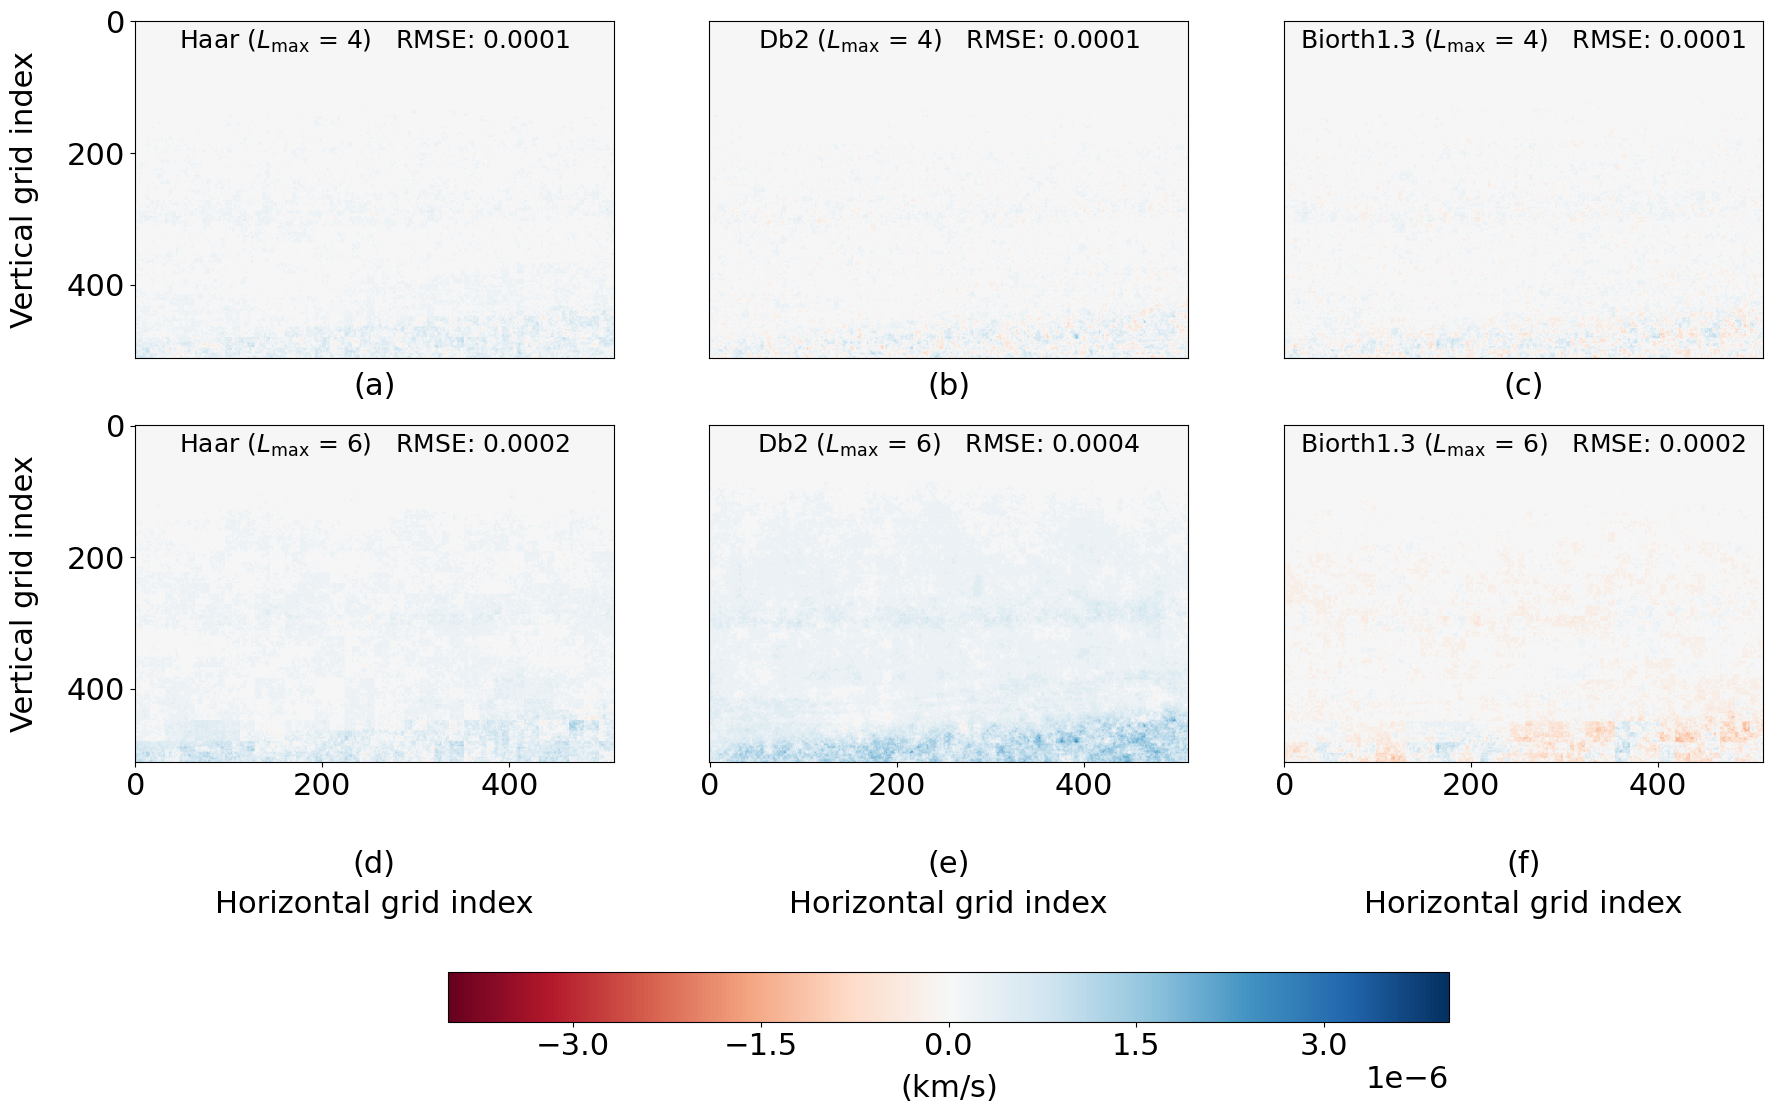

In [7]:
wavelet_type_4plotting = ['haar', 'db2', 'bior1.3']

wavelet_display_names = {
    'haar': 'Haar',
    'db2': 'Db2',
    'bior1.3': 'Biorth1.3'
}
max_levels_4plotting = [4, 6]

# Remove `constrained_layout=True` to avoid conflict
fig, axes = plt.subplots(len(max_levels_4plotting), len(wavelet_type_4plotting), 
                         figsize=(21, 13), gridspec_kw={'hspace': 0.2, 'wspace': 0.2})

# Generate alphabetic labels (A, B, C, ...)
labels = list(string.ascii_lowercase)
label_fontsize = 22  # Increased font size for clarity

xlabel_txt = 'Horizontal grid index'
ylabel_txt = 'Vertical grid index'

letter_offset = -0.12      # how far below the image (axes fraction)
labelpad_bottom = 35       # space between image and bottom X-label

for row_idx, max_level in enumerate(max_levels_4plotting):
    for col_idx, wt in enumerate(wavelet_type_4plotting):
        ax = axes[row_idx, col_idx]
        im = ax.imshow(differences[wt][max_level] / 1000.0, cmap='RdBu', 
                       aspect='auto', vmin=-0.004/1000.0, vmax=0.004/1000.0)
        
        # 1) your little subplot letter
        label_idx = row_idx * len(wavelet_type_4plotting) + col_idx
        # for bottom row, we’ll do a multiline xlabel…
        if row_idx == len(max_levels_4plotting) - 1:
            ax.set_xlabel(
                f'({labels[label_idx]})\n{xlabel_txt}',
                fontsize=label_fontsize,
                labelpad=labelpad_bottom,
                linespacing=1.5
            )
            ax.tick_params(labelsize=22)
        else:
            ax.set_xlabel(f'({labels[label_idx]})', fontsize=label_fontsize, labelpad=10)
            ax.set_xticks([])

        # 2) y-ticks only for first column, plus a ylabel there
        if col_idx == 0:
            ax.set_ylabel(ylabel_txt, fontsize=22, labelpad=20)
            ax.tick_params(labelsize=22)
        else:
            ax.set_yticks([])

        # ax.text(0.67, 0.94, f"RMSE: {metrics_maxL_test[wt][max_level]['rmse']:.4f}", fontsize=16, ha='right', va='center', transform=ax.transAxes)
        ax.text(0.5, 0.94, fr"{wavelet_display_names[wt]} ($L_{{\max}}$ = {max_level})   RMSE: {metrics_maxL_test[wt][max_level]['rmse']:.4f}", fontsize=18, ha='center', va='center', transform=ax.transAxes)

# **First apply tight_layout(), then adjust the bottom margin**

# **Use automatic colorbar placement**
cbar = fig.colorbar(im, ax=axes, orientation='horizontal', fraction=0.05, pad=0.08)
cbar.ax.tick_params(labelsize=22)  # Large colorbar tick labels
cbar.set_label(r"($\mathrm{km/s}$)", fontsize=22, labelpad=8)

# **Ensure good spacing of colorbar ticks**
cbar.locator = ticker.MaxNLocator(nbins=6)
cbar.update_ticks()
# Increase font size of the offset text (e.g., "1e-6")
cbar.ax.xaxis.offsetText.set_fontsize(22)  # or any desired fontsize

# fig.tight_layout()
fig.subplots_adjust(bottom=0.31)  # Push colorbar lower
# plt.savefig(f'./plots/Kimb_Test_Max_LevelDecompositions_diff_IP512x512_5Wavelets_Lmax4_and_Lmax6_ImageRec512x512_RMSEcalc_4paper_withLabels.png', dpi=300, bbox_inches='tight')
plt.show()


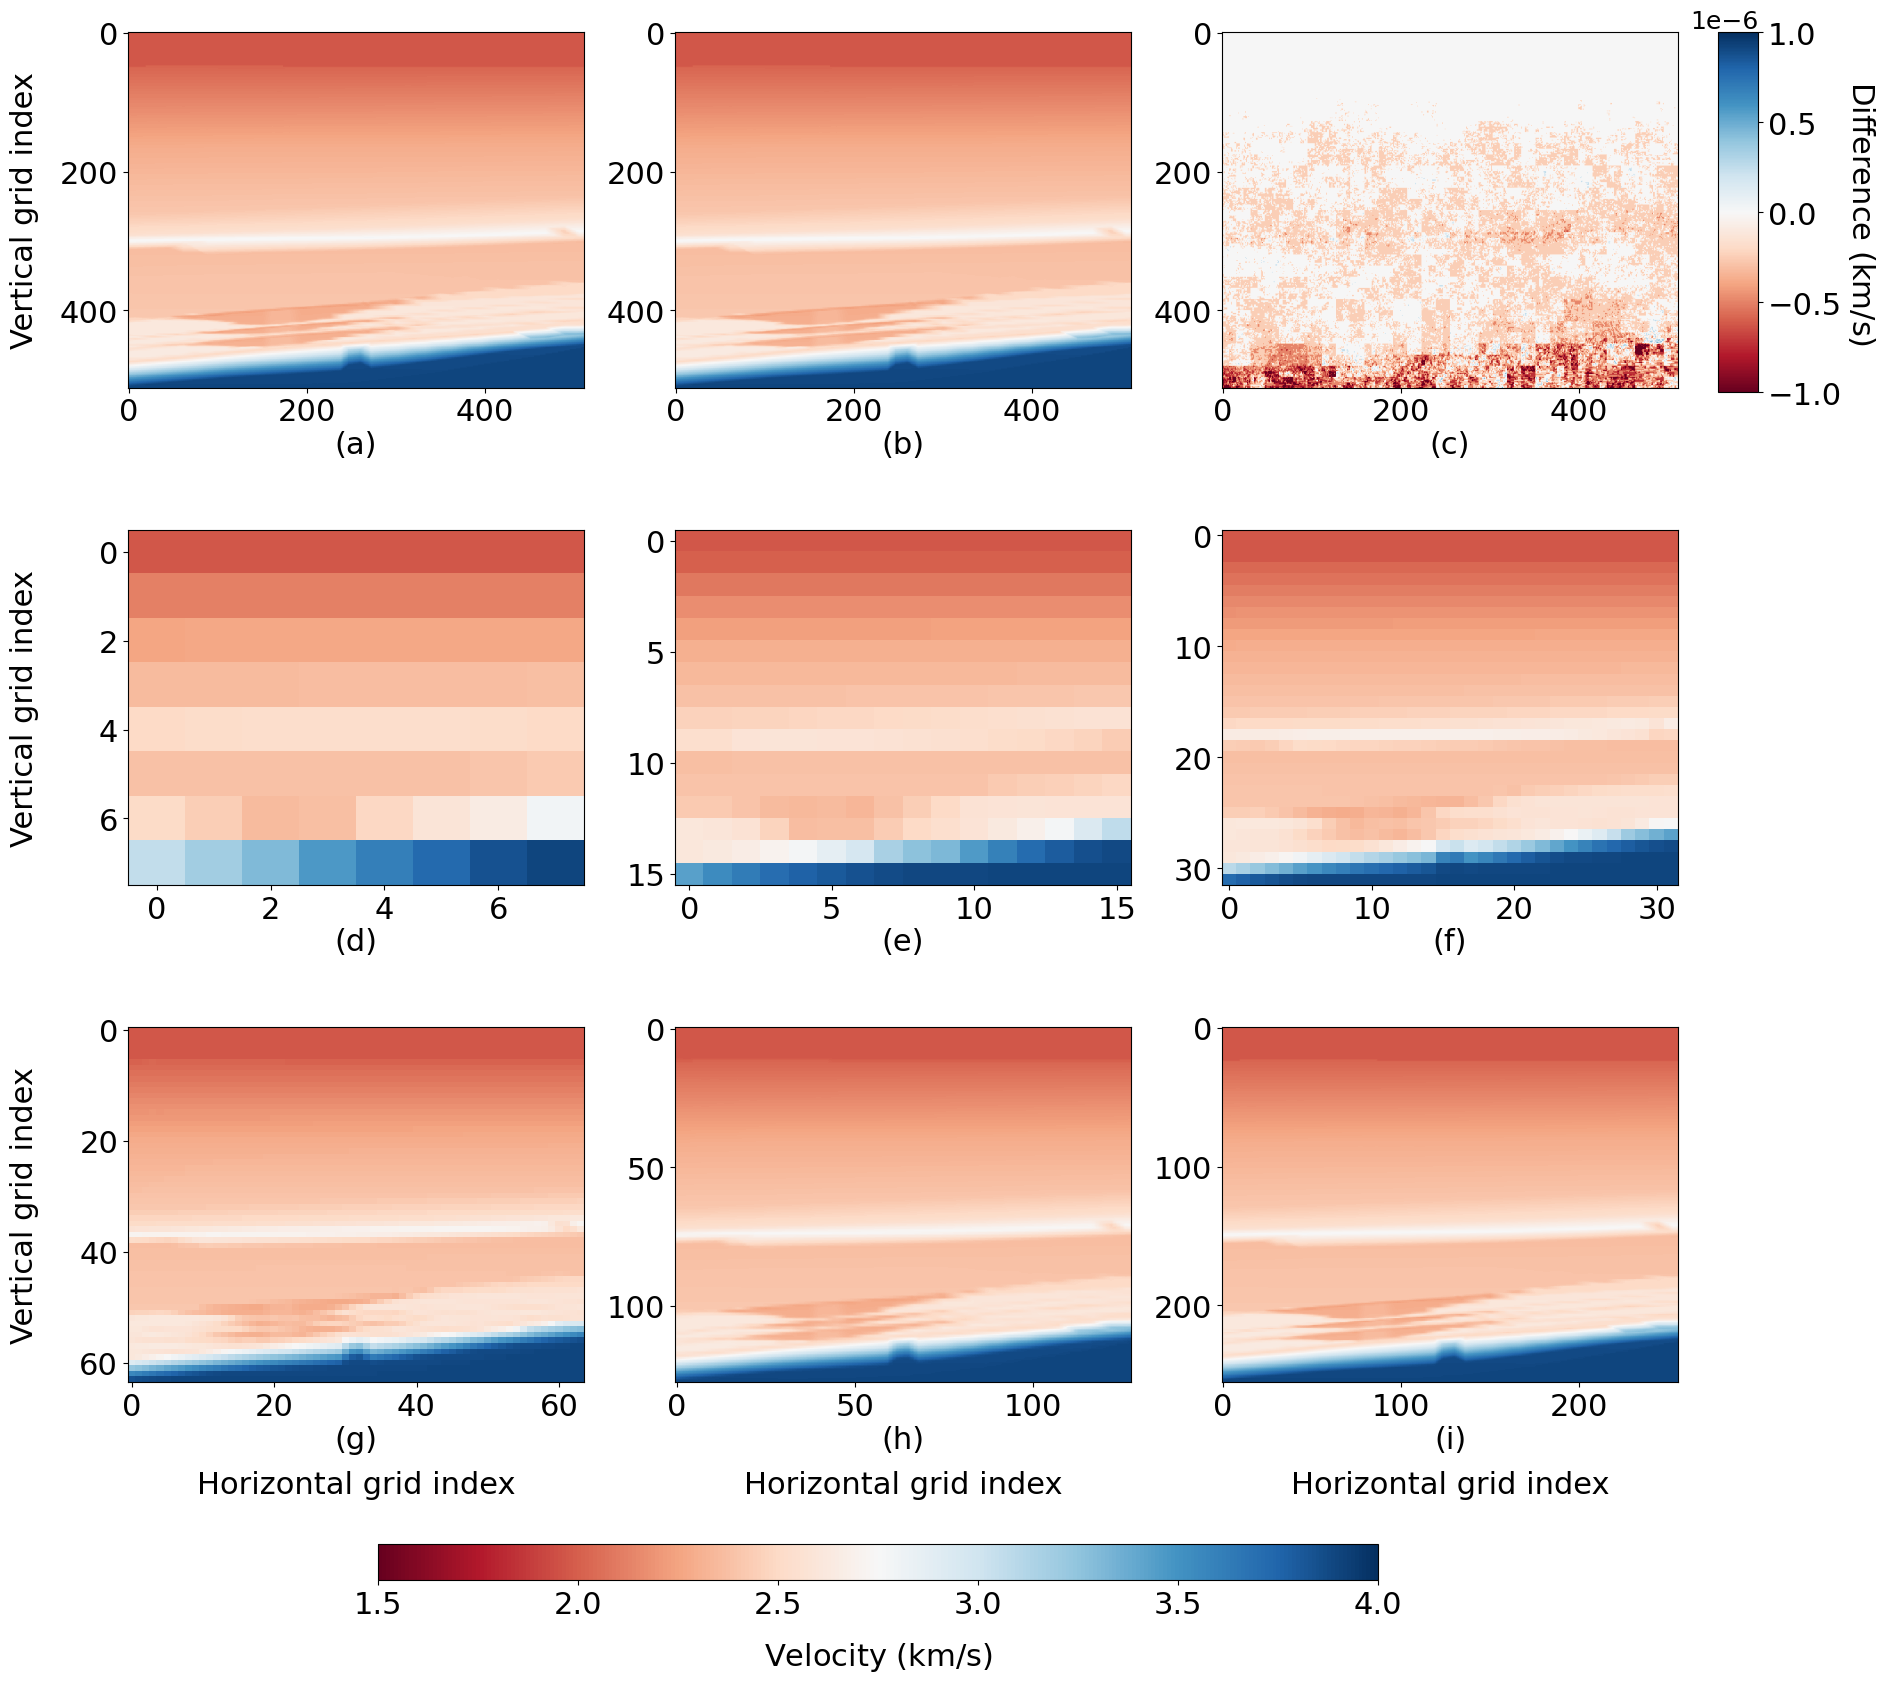

In [8]:
max_level_to_plot = 6
wavelet = 'haar'

# Collect the images for consistent color scaling
all_images = [
    reconstruct_images_IP512[wavelet][max_level_to_plot]['accumulative_levels'][i]
    for i in range(max_level_to_plot + 1)
]
vmin2 = 1.5  
vmax2 = 4.0  

fig, axes = plt.subplots(
    3,
    3,
    figsize=(20, 18),
    gridspec_kw={'hspace': 0.4, 'wspace': 0.2}
)
fig.subplots_adjust(hspace=0.6, top=0.88)  

labels = list(string.ascii_lowercase)
label_fontsize = 22  # 

# -------------------------------------------------------------------------
# FIRST ROW ----------------------------------------------------------------
# -------------------------------------------------------------------------
ax = axes.flat[0]
img = vp_upsamp512x512
im1 = ax.imshow(
    img / 1000.0,
    cmap='RdBu',
    aspect='auto',
    vmin=vmin2,
    vmax=vmax2
)
ax.tick_params(axis='x', labelsize=22)
ax.tick_params(axis='y', labelsize=22)

ax = axes.flat[1]
img = reconstruct_images_IP512[wavelet][max_level_to_plot]['accumulative_levels'][6]
im1 = ax.imshow(
    img / 1000.0,
    cmap='RdBu',
    aspect='auto',
    vmin=vmin2,
    vmax=vmax2
)
ax.tick_params(axis='x', labelsize=22)
ax.tick_params(axis='y', labelsize=22)

ax = axes.flat[2]
img = (
    reconstruct_images_IP512[wavelet][max_level_to_plot]['accumulative_levels'][6]
    - vp_upsamp512x512
)
im2 = ax.imshow(
    img / 1000.0,
    cmap='RdBu',
    aspect='auto',
    vmin=-0.001 / 1000.0,
    vmax=0.001 / 1000.0
)
ax.tick_params(axis='x', labelsize=22)
ax.tick_params(axis='y', labelsize=22)

# -------------------------------------------------------------------------
# REMAINING PANELS ---------------------------------------------------------
# -------------------------------------------------------------------------
for i in range(0, max_level_to_plot):
    ax = axes.flat[i + 3]
    img = reconstruct_images_IP512[wavelet][max_level_to_plot]['accumulative_levels'][i]
    im1 = ax.imshow(
        img / 1000.0,
        cmap='RdBu',
        aspect='auto',
        vmin=vmin2,
        vmax=vmax2
    )
    ax.tick_params(axis='x', labelsize=22)
    ax.tick_params(axis='y', labelsize=22)

# -------------------------------------------------------------------------
xlabel_txt = 'Horizontal grid index'
ylabel_txt = 'Vertical grid index'
letter_offset = -0.12      # how far below the image (axes fraction)
labelpad_bottom = 35       # space between image and bottom X-label

for idx, ax in enumerate(axes.flat):
    row, col = divmod(idx, 3)  # 3 columns → (row, col)

    # -- panel letter centred below each image ----------------------------
    ax.text(
        0.5,
        letter_offset,
        f'({labels[idx]})',
        transform=ax.transAxes,
        fontsize=label_fontsize,
        ha='center',
        va='top'
    )

    # -- Y axis label only for first column -------------------------------
    if col == 0:
        ax.set_ylabel(ylabel_txt, fontsize=22, labelpad=15)
    else:
        ax.set_ylabel('')

    # -- X axis label only for bottom row ---------------------------------
    if row == 2:
        ax.set_xlabel(xlabel_txt, fontsize=22, labelpad=labelpad_bottom)
    else:
        ax.set_xlabel('')

    # -- make sure tick labels are visible everywhere ---------------------
    ax.tick_params(axis='x', labelsize=22, labelbottom=True)
    ax.tick_params(axis='y', labelsize=22, labelleft=True)

# Align Y-labels in the first column so they sit on one vertical line
fig.align_ylabels(axes[:, 0])

# -------------------------------------------------------------------------
# COLOUR-BARS (unchanged)
# -------------------------------------------------------------------------
cbar_ax1 = fig.add_axes([0.25, 0.02, 0.5, 0.02])  # [left, bottom, width, height]
cbar1 = fig.colorbar(im1, cax=cbar_ax1, orientation='horizontal')
cbar1.ax.tick_params(labelsize=22)
cbar1.set_label(r"Velocity ($\mathrm{km/s}$)", fontsize=22, labelpad=15)
cbar1.ax.xaxis.set_label_position("bottom")

cbar_ax2 = fig.add_axes([0.92, 0.68, 0.02, 0.2])  # Placed vertically to the side
cbar2 = fig.colorbar(im2, cax=cbar_ax2, orientation='vertical')
cbar2.ax.yaxis.set_label_position("right")
cbar2.ax.tick_params(labelsize=22)
cbar2.set_label(r"Difference ($\mathrm{km/s}$)", fontsize=22, labelpad=25, rotation=270)
plt.subplots_adjust(bottom=0.13)  # Push colorbar lower
# -------------------------------------------------------------------------
# SAVE / SHOW (unchanged)
# -------------------------------------------------------------------------
cbar1.ax.xaxis.get_offset_text().set_fontsize(18)   # horizontal bar
cbar2.ax.yaxis.get_offset_text().set_fontsize(18)   # vertical bar
# plt.savefig('./plots/Kimb_Test_Rec_velocity_Haar_with_Lmax6_IP512x512_4paper_withoutTitles.png', dpi=300, bbox_inches='tight')
plt.show()


In [9]:
reconstruct_images_IP512_haar_MaxL6_recImage512x512_downsamp350x600 = (F.interpolate(torch.tensor(reconstruct_images_IP512['haar'][6]['accumulative_levels'][6], dtype=torch.float32).unsqueeze(0).unsqueeze(0), size=(350, 600), mode='nearest-exact').squeeze().numpy())
reconstruct_images_IP512_haar_MaxL6_recImage256x256_downsamp350x600 = (F.interpolate(torch.tensor(reconstruct_images_IP512['haar'][6]['accumulative_levels'][5], dtype=torch.float32).unsqueeze(0).unsqueeze(0), size=(350, 600), mode='nearest-exact').squeeze().numpy())
reconstruct_images_IP512_haar_MaxL6_recImage128x128_downsamp350x600 = (F.interpolate(torch.tensor(reconstruct_images_IP512['haar'][6]['accumulative_levels'][4], dtype=torch.float32).unsqueeze(0).unsqueeze(0), size=(350, 600), mode='nearest-exact').squeeze().numpy())

diff_IP512_orig_haar_MaxL6_recImage512x512_downsamp350x600 = vp - reconstruct_images_IP512_haar_MaxL6_recImage512x512_downsamp350x600
diff_IP512_orig_haar_MaxL6_recImage256x256_downsamp350x600 = vp - reconstruct_images_IP512_haar_MaxL6_recImage256x256_downsamp350x600
diff_IP512_orig_haar_MaxL6_recImage128x128_downsamp350x600 = vp - reconstruct_images_IP512_haar_MaxL6_recImage128x128_downsamp350x600
### rmse
rmse_IP512_orig_haar_MaxL6_recImage512x512_downsamp350x600 =  np.sqrt(np.mean((vp - reconstruct_images_IP512_haar_MaxL6_recImage512x512_downsamp350x600)**2))
rmse_IP512_orig_haar_MaxL6_recImage256x256_downsamp350x600 =  np.sqrt(np.mean((vp - reconstruct_images_IP512_haar_MaxL6_recImage256x256_downsamp350x600)**2))
rmse_IP512_orig_haar_MaxL6_recImage128x128_downsamp350x600 =  np.sqrt(np.mean((vp - reconstruct_images_IP512_haar_MaxL6_recImage128x128_downsamp350x600)**2))
### ssim
ssim_IP512_orig_haar_MaxL6_recImage512x512_downsamp350x600 = ssim(vp, reconstruct_images_IP512_haar_MaxL6_recImage512x512_downsamp350x600, data_range=vp.max() - vp.min())
ssim_IP512_orig_haar_MaxL6_recImage256x256_downsamp350x600 = ssim(vp, reconstruct_images_IP512_haar_MaxL6_recImage256x256_downsamp350x600, data_range=vp.max() - vp.min())
ssim_IP512_orig_haar_MaxL6_recImage128x128_downsamp350x600 = ssim(vp, reconstruct_images_IP512_haar_MaxL6_recImage128x128_downsamp350x600, data_range=vp.max() - vp.min())
#########################
reconstruct_images_IP512_db2_MaxL6_recImage512x512_downsamp350x600 = (F.interpolate(torch.tensor(reconstruct_images_IP512['db2'][6]['accumulative_levels'][6], dtype=torch.float32).unsqueeze(0).unsqueeze(0), size=(350, 600), mode='nearest-exact').squeeze().numpy())
reconstruct_images_IP512_db2_MaxL6_recImage258x258_downsamp350x600 = (F.interpolate(torch.tensor(reconstruct_images_IP512['db2'][6]['accumulative_levels'][5], dtype=torch.float32).unsqueeze(0).unsqueeze(0), size=(350, 600), mode='nearest-exact').squeeze().numpy())
reconstruct_images_IP512_db2_MaxL6_recImage130x130_downsamp350x600 = (F.interpolate(torch.tensor(reconstruct_images_IP512['db2'][6]['accumulative_levels'][4], dtype=torch.float32).unsqueeze(0).unsqueeze(0), size=(350, 600), mode='nearest-exact').squeeze().numpy())

diff_IP512_orig_db2_MaxL6_recImage512x512_downsamp350x600 = vp - reconstruct_images_IP512_db2_MaxL6_recImage512x512_downsamp350x600
diff_IP512_orig_db2_MaxL6_recImage258x258_downsamp350x600 = vp - reconstruct_images_IP512_db2_MaxL6_recImage258x258_downsamp350x600
diff_IP512_orig_db2_MaxL6_recImage130x130_downsamp350x600 = vp - reconstruct_images_IP512_db2_MaxL6_recImage130x130_downsamp350x600
### rmse
rmse_IP512_orig_db2_MaxL6_recImage512x512_downsamp350x600 =  np.sqrt(np.mean((vp - reconstruct_images_IP512_db2_MaxL6_recImage512x512_downsamp350x600)**2))
rmse_IP512_orig_db2_MaxL6_recImage258x258_downsamp350x600 =  np.sqrt(np.mean((vp - reconstruct_images_IP512_db2_MaxL6_recImage258x258_downsamp350x600)**2))
rmse_IP512_orig_db2_MaxL6_recImage130x130_downsamp350x600 =  np.sqrt(np.mean((vp - reconstruct_images_IP512_db2_MaxL6_recImage130x130_downsamp350x600)**2))
### ssim
ssim_IP512_orig_db2_MaxL6_recImage512x512_downsamp350x600 = ssim(vp, reconstruct_images_IP512_db2_MaxL6_recImage512x512_downsamp350x600, data_range=vp.max() - vp.min())
ssim_IP512_orig_db2_MaxL6_recImage258x258_downsamp350x600 = ssim(vp, reconstruct_images_IP512_db2_MaxL6_recImage258x258_downsamp350x600, data_range=vp.max() - vp.min())
ssim_IP512_orig_db2_MaxL6_recImage130x130_downsamp350x600 = ssim(vp, reconstruct_images_IP512_db2_MaxL6_recImage130x130_downsamp350x600, data_range=vp.max() - vp.min())
#########################
reconstruct_images_IP512_sym2_MaxL6_recImage512x512_downsamp350x600 = (F.interpolate(torch.tensor(reconstruct_images_IP512['sym2'][6]['accumulative_levels'][6], dtype=torch.float32).unsqueeze(0).unsqueeze(0), size=(350, 600), mode='nearest-exact').squeeze().numpy())
reconstruct_images_IP512_sym2_MaxL6_recImage258x258_downsamp350x600 = (F.interpolate(torch.tensor(reconstruct_images_IP512['sym2'][6]['accumulative_levels'][5], dtype=torch.float32).unsqueeze(0).unsqueeze(0), size=(350, 600), mode='nearest-exact').squeeze().numpy())
reconstruct_images_IP512_sym2_MaxL6_recImage130x130_downsamp350x600 = (F.interpolate(torch.tensor(reconstruct_images_IP512['sym2'][6]['accumulative_levels'][4], dtype=torch.float32).unsqueeze(0).unsqueeze(0), size=(350, 600), mode='nearest-exact').squeeze().numpy())

diff_IP512_orig_sym2_MaxL6_recImage512x512_downsamp350x600 = vp - reconstruct_images_IP512_sym2_MaxL6_recImage512x512_downsamp350x600
diff_IP512_orig_sym2_MaxL6_recImage258x258_downsamp350x600 = vp - reconstruct_images_IP512_sym2_MaxL6_recImage258x258_downsamp350x600
diff_IP512_orig_sym2_MaxL6_recImage130x130_downsamp350x600 = vp - reconstruct_images_IP512_sym2_MaxL6_recImage130x130_downsamp350x600
### rmse
rmse_IP512_orig_sym2_MaxL6_recImage512x512_downsamp350x600 =  np.sqrt(np.mean((vp - reconstruct_images_IP512_sym2_MaxL6_recImage512x512_downsamp350x600)**2))
rmse_IP512_orig_sym2_MaxL6_recImage258x258_downsamp350x600 =  np.sqrt(np.mean((vp - reconstruct_images_IP512_sym2_MaxL6_recImage258x258_downsamp350x600)**2))
rmse_IP512_orig_sym2_MaxL6_recImage130x130_downsamp350x600 =  np.sqrt(np.mean((vp - reconstruct_images_IP512_sym2_MaxL6_recImage130x130_downsamp350x600)**2))
### ssim
ssim_IP512_orig_sym2_MaxL6_recImage512x512_downsamp350x600 = ssim(vp, reconstruct_images_IP512_sym2_MaxL6_recImage512x512_downsamp350x600, data_range=vp.max() - vp.min())
ssim_IP512_orig_sym2_MaxL6_recImage258x258_downsamp350x600 = ssim(vp, reconstruct_images_IP512_sym2_MaxL6_recImage258x258_downsamp350x600, data_range=vp.max() - vp.min())
ssim_IP512_orig_sym2_MaxL6_recImage130x130_downsamp350x600 = ssim(vp, reconstruct_images_IP512_sym2_MaxL6_recImage130x130_downsamp350x600, data_range=vp.max() - vp.min())
#########################
reconstruct_images_IP512_coif2_MaxL6_recImage512x512_downsamp350x600 = (F.interpolate(torch.tensor(reconstruct_images_IP512['coif2'][6]['accumulative_levels'][6], dtype=torch.float32).unsqueeze(0).unsqueeze(0), size=(350, 600), mode='nearest-exact').squeeze().numpy())
reconstruct_images_IP512_coif2_MaxL6_recImage262x262_downsamp350x600 = (F.interpolate(torch.tensor(reconstruct_images_IP512['coif2'][6]['accumulative_levels'][5], dtype=torch.float32).unsqueeze(0).unsqueeze(0), size=(350, 600), mode='nearest-exact').squeeze().numpy())
reconstruct_images_IP512_coif2_MaxL6_recImage136x136_downsamp350x600 = (F.interpolate(torch.tensor(reconstruct_images_IP512['coif2'][6]['accumulative_levels'][4], dtype=torch.float32).unsqueeze(0).unsqueeze(0), size=(350, 600), mode='nearest-exact').squeeze().numpy())

diff_IP512_orig_coif2_MaxL6_recImage512x512_downsamp350x600 = vp - reconstruct_images_IP512_coif2_MaxL6_recImage512x512_downsamp350x600
diff_IP512_orig_coif2_MaxL6_recImage262x262_downsamp350x600 = vp - reconstruct_images_IP512_coif2_MaxL6_recImage262x262_downsamp350x600
diff_IP512_orig_coif2_MaxL6_recImage136x136_downsamp350x600 = vp - reconstruct_images_IP512_coif2_MaxL6_recImage136x136_downsamp350x600
### rmse
rmse_IP512_orig_coif2_MaxL6_recImage512x512_downsamp350x600 =  np.sqrt(np.mean((vp - reconstruct_images_IP512_coif2_MaxL6_recImage512x512_downsamp350x600)**2))
rmse_IP512_orig_coif2_MaxL6_recImage262x262_downsamp350x600 =  np.sqrt(np.mean((vp - reconstruct_images_IP512_coif2_MaxL6_recImage262x262_downsamp350x600)**2))
rmse_IP512_orig_coif2_MaxL6_recImage136x136_downsamp350x600 =  np.sqrt(np.mean((vp - reconstruct_images_IP512_coif2_MaxL6_recImage136x136_downsamp350x600)**2))
### ssim
ssim_IP512_orig_coif2_MaxL6_recImage512x512_downsamp350x600 = ssim(vp, reconstruct_images_IP512_coif2_MaxL6_recImage512x512_downsamp350x600, data_range=vp.max() - vp.min())
ssim_IP512_orig_coif2_MaxL6_recImage262x262_downsamp350x600 = ssim(vp, reconstruct_images_IP512_coif2_MaxL6_recImage262x262_downsamp350x600, data_range=vp.max() - vp.min())
ssim_IP512_orig_coif2_MaxL6_recImage136x136_downsamp350x600 = ssim(vp, reconstruct_images_IP512_coif2_MaxL6_recImage136x136_downsamp350x600, data_range=vp.max() - vp.min())
#########################
reconstruct_images_IP512_bior13_MaxL6_recImage512x512_downsamp350x600 = (F.interpolate(torch.tensor(reconstruct_images_IP512['bior1.3'][6]['accumulative_levels'][6], dtype=torch.float32).unsqueeze(0).unsqueeze(0), size=(350, 600), mode='nearest-exact').squeeze().numpy())
reconstruct_images_IP512_bior13_MaxL6_recImage258x258_downsamp350x600 = (F.interpolate(torch.tensor(reconstruct_images_IP512['bior1.3'][6]['accumulative_levels'][5], dtype=torch.float32).unsqueeze(0).unsqueeze(0), size=(350, 600), mode='nearest-exact').squeeze().numpy())
reconstruct_images_IP512_bior13_MaxL6_recImage130x130_downsamp350x600 = (F.interpolate(torch.tensor(reconstruct_images_IP512['bior1.3'][6]['accumulative_levels'][4], dtype=torch.float32).unsqueeze(0).unsqueeze(0), size=(350, 600), mode='nearest-exact').squeeze().numpy())

diff_IP512_orig_bior13_MaxL6_recImage512x512_downsamp350x600 = vp - reconstruct_images_IP512_bior13_MaxL6_recImage512x512_downsamp350x600
diff_IP512_orig_bior13_MaxL6_recImage258x258_downsamp350x600 = vp - reconstruct_images_IP512_bior13_MaxL6_recImage258x258_downsamp350x600
diff_IP512_orig_bior13_MaxL6_recImage130x130_downsamp350x600 = vp - reconstruct_images_IP512_bior13_MaxL6_recImage130x130_downsamp350x600
### rmse
rmse_IP512_orig_bior13_MaxL6_recImage512x512_downsamp350x600 =  np.sqrt(np.mean((vp - reconstruct_images_IP512_bior13_MaxL6_recImage512x512_downsamp350x600)**2))
rmse_IP512_orig_bior13_MaxL6_recImage258x258_downsamp350x600 =  np.sqrt(np.mean((vp - reconstruct_images_IP512_bior13_MaxL6_recImage258x258_downsamp350x600)**2))
rmse_IP512_orig_bior13_MaxL6_recImage130x130_downsamp350x600 =  np.sqrt(np.mean((vp - reconstruct_images_IP512_bior13_MaxL6_recImage130x130_downsamp350x600)**2))
### ssim
ssim_IP512_orig_bior13_MaxL6_recImage512x512_downsamp350x600 = ssim(vp, reconstruct_images_IP512_bior13_MaxL6_recImage512x512_downsamp350x600, data_range=vp.max() - vp.min())
ssim_IP512_orig_bior13_MaxL6_recImage258x258_downsamp350x600 = ssim(vp, reconstruct_images_IP512_bior13_MaxL6_recImage258x258_downsamp350x600, data_range=vp.max() - vp.min())
ssim_IP512_orig_bior13_MaxL6_recImage130x130_downsamp350x600 = ssim(vp, reconstruct_images_IP512_bior13_MaxL6_recImage130x130_downsamp350x600, data_range=vp.max() - vp.min())

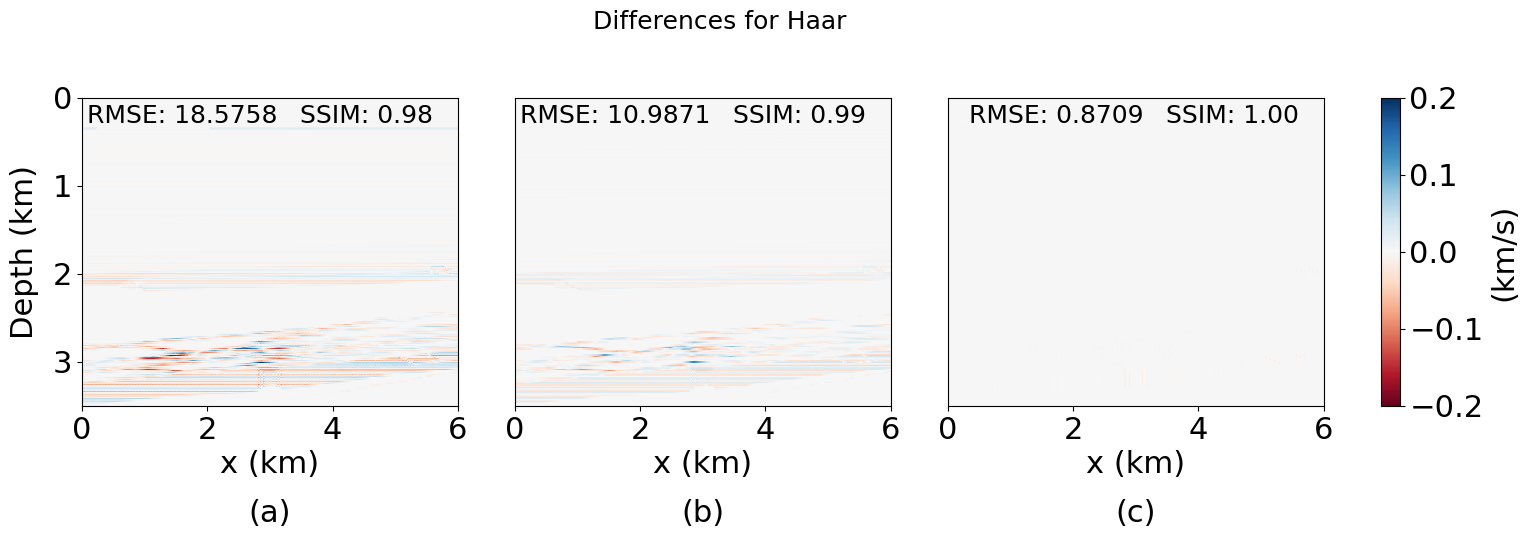

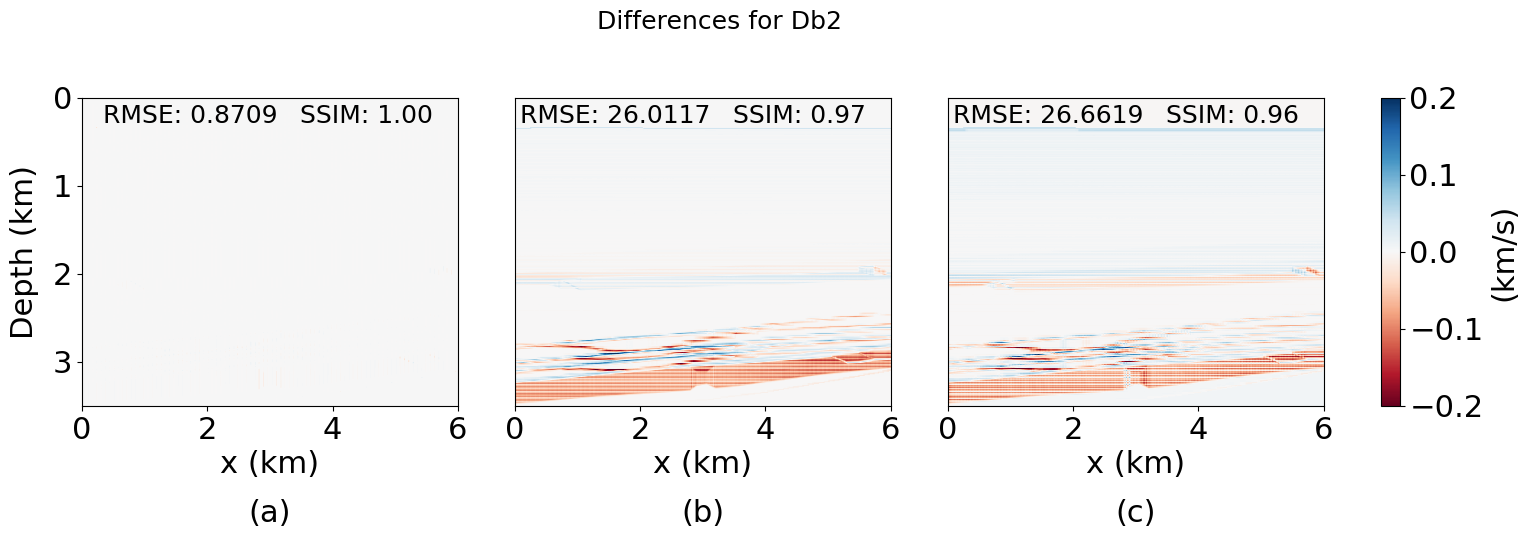

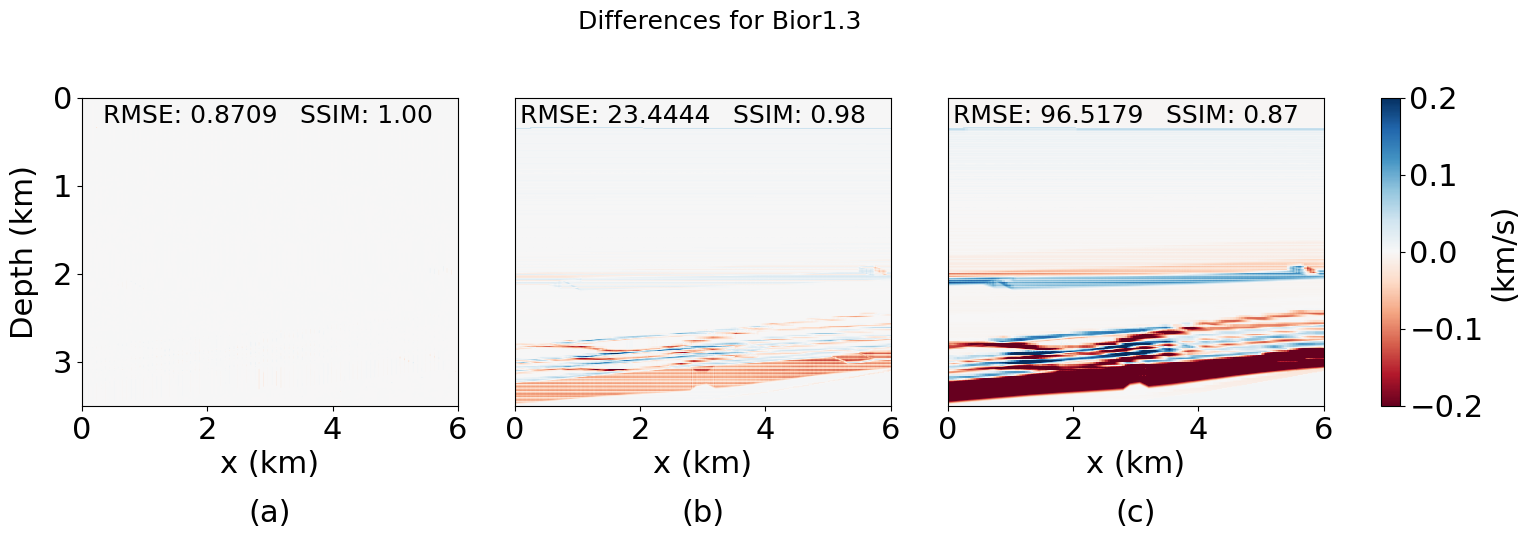

In [10]:
# Dictionary of wavelet names and their corresponding data
wavelet_data_4plotting = {
    'Haar': {
        'data': [
            diff_IP512_orig_haar_MaxL6_recImage128x128_downsamp350x600,
            diff_IP512_orig_haar_MaxL6_recImage256x256_downsamp350x600,
            diff_IP512_orig_haar_MaxL6_recImage512x512_downsamp350x600
        ],
        'titles': ['ImgRec 128x128', 'ImgRec 256x256', 'ImgRec 512x512'],
        'vmax': [0.2, 0.2, 0.2],
        'vmin': [-0.2, -0.2, -0.2],
        'rmse': [rmse_IP512_orig_haar_MaxL6_recImage128x128_downsamp350x600,
                 rmse_IP512_orig_haar_MaxL6_recImage256x256_downsamp350x600, 
                 rmse_IP512_orig_haar_MaxL6_recImage512x512_downsamp350x600],
        'ssim': [ssim_IP512_orig_haar_MaxL6_recImage128x128_downsamp350x600,
                 ssim_IP512_orig_haar_MaxL6_recImage256x256_downsamp350x600, 
                 ssim_IP512_orig_haar_MaxL6_recImage512x512_downsamp350x600]
    },
    'Db2': {
    'data': [
        diff_IP512_orig_db2_MaxL6_recImage512x512_downsamp350x600,
        diff_IP512_orig_db2_MaxL6_recImage258x258_downsamp350x600,
        diff_IP512_orig_db2_MaxL6_recImage130x130_downsamp350x600
    ],
    'titles': ['ImgRec 512x512', 'ImgRec 258x258', 'ImgRec 130x130'],
    'vmax': [0.2, 0.2, 0.2],
    'vmin': [-0.2, -0.2, -0.2],
    'rmse': [rmse_IP512_orig_db2_MaxL6_recImage512x512_downsamp350x600, 
                rmse_IP512_orig_db2_MaxL6_recImage258x258_downsamp350x600, 
                rmse_IP512_orig_db2_MaxL6_recImage130x130_downsamp350x600],
    'ssim': [ssim_IP512_orig_db2_MaxL6_recImage512x512_downsamp350x600,
                ssim_IP512_orig_db2_MaxL6_recImage258x258_downsamp350x600,
                ssim_IP512_orig_db2_MaxL6_recImage130x130_downsamp350x600]
},
'Bior1.3': {
    'data': [
        diff_IP512_orig_bior13_MaxL6_recImage512x512_downsamp350x600,
        diff_IP512_orig_bior13_MaxL6_recImage258x258_downsamp350x600,
        diff_IP512_orig_bior13_MaxL6_recImage130x130_downsamp350x600
    ],
    'titles': ['ImgRec 512x512', 'ImgRec 258x258', 'ImgRec 130x130'],
    'vmax': [0.2, 0.2, 0.2],
    'vmin': [-0.2, -0.2, -0.2],
    'rmse': [rmse_IP512_orig_bior13_MaxL6_recImage512x512_downsamp350x600, 
                rmse_IP512_orig_bior13_MaxL6_recImage258x258_downsamp350x600, 
                rmse_IP512_orig_bior13_MaxL6_recImage130x130_downsamp350x600],
    'ssim': [ssim_IP512_orig_bior13_MaxL6_recImage512x512_downsamp350x600,
                ssim_IP512_orig_bior13_MaxL6_recImage258x258_downsamp350x600,
                ssim_IP512_orig_bior13_MaxL6_recImage130x130_downsamp350x600]
}
}

extents = [0, 6, 3.5, 0]

# Generate alphabetic labels (A, B, C, ...)
labels = list(string.ascii_lowercase)
label_fontsize = 22  # Increased font size for clarity

# Loop through each wavelet
for wavelet, details in wavelet_data_4plotting.items():
    fig = plt.figure(figsize=(17, 4))
    gs = GridSpec(1, 4, width_ratios=[1, 1, 1, 0.05], figure=fig)  # 3 plots + 1 for colorbar

    axes = []
    for i, data in enumerate(details['data']):
        ax = fig.add_subplot(gs[0, i])
        im = ax.imshow(data/1000.0, cmap='RdBu', aspect='auto', vmax=details['vmax'][i], vmin=details['vmin'][i], extent=extents)
        # ax.set_title(details['titles'][i], pad=16, fontsize=18)
        ax.text(0.5, -0.35, f'({labels[i]})', fontsize=label_fontsize, ha='center', va='center', transform=ax.transAxes)

        # Keep yticks only for the first plot
        if i != 0:
            ax.set_yticks([])

        if i == 0:
            ax.set_ylabel('Depth (km)', fontsize=22, labelpad=10)
        else:
            ax.set_ylabel('')

        ax.set_xlabel('x (km)', fontsize=22)
        ax.tick_params(axis='both', which='major', labelsize=22)  # Change labelsize as needed
        ax.tick_params(axis='both', which='minor', labelsize=22)
        ## write rmse values to figure on the x axis
        ax.text(0.52, 0.94, f"RMSE: {details['rmse'][i]:.4f}", fontsize=18, ha='right', va='center', transform=ax.transAxes)
        ax.text(0.58, 0.94, f"SSIM: {details['ssim'][i]:.2f}", fontsize=18, ha='left', va='center', transform=ax.transAxes)
        axes.append(ax)

    # Add a single colorbar to the right
    cbar_ax = fig.add_subplot(gs[0, 3])
    cbar = fig.colorbar(im, cax=cbar_ax)
    cbar.ax.tick_params(labelsize=22)  # Adjust colorbar tick size if needed
    cbar.set_label('(km/s)', fontsize=22)  # Add colorbar label

    # Add a title for the entire figure
    plt.suptitle(f'Differences for {wavelet}', fontsize=18, y=1.1)
    plt.subplots_adjust(hspace=0.3, wspace=0.2)  # Adjust spacing

    # Save the figure
    # plt.savefig(f'./plots/Kimb_Test_diff_orig_and_IP512x512_Haar_MaxL6_recImages_downsamp350x600_RMSEcalc_4paper_withLabels.png', dpi=300, bbox_inches='tight')
    plt.show()